# Double Machine Learning Simplified 

## Part 2: Extensions & the CATE

In [1]:
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf
from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from stargazer.stargazer import Stargazer
import graphviz

In [17]:
x5 = np.random.normal(size=1000)
x3 = np.random.normal(size=1000)
x4 = x5 + x3
x1 = x3 + x4
y = x4 + x5

df = pd.DataFrame(np.array([x5,x3,x4,x1,y]).T
                  ,columns=["x5","x3","x4","x1",'y'])

mod = smf.ols(formula='y ~ 1 + x1 + x4 + x3 + x5', data = df).fit()

print(mod.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 3.654e+33
Date:                Fri, 11 Aug 2023   Prob (F-statistic):               0.00
Time:                        19:58:07   Log-Likelihood:                 33342.
No. Observations:                1000   AIC:                        -6.668e+04
Df Residuals:                     997   BIC:                        -6.666e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     3.4e-16   2.54e-17     13.371      0.0

### Linear DML

In [2]:
N = 100_000

# Confounders
age = np.random.randint(low=18,high=75,size=N)
num_social_media_profiles = np.random.choice([0,1,2,3,4,5,6,7,8,9,10], size = N)
yr_membership = np.random.choice([0,1,2,3,4,5,6,7,8,9,10], size = N)

# Covariates
X = np.random.normal(loc=50, scale = 25, size = N)

# Error Terms
ε1 = np.random.normal(loc=20,scale=5,size=N)
ε2 = np.random.normal(loc=40,scale=15,size=N)

# Treatment (T)
time_on_website = np.maximum( np.random.normal(loc=10, scale=5, size=N) 
                             - 0.01*age 
                             - 0.001*age**2 
                             + num_social_media_profiles 
                             - 0.01 * num_social_media_profiles**2
                             - 0.01*(age * num_social_media_profiles)
                             + 0.2 * yr_membership
                             + 0.001 * yr_membership**2
                             - 0.01 * (age * yr_membership)
                             + 0.2 * (num_social_media_profiles * yr_membership)
                             + 0.01 * (num_social_media_profiles * np.log(age) * age * yr_membership**(1/2))
                             + ε1
                               ,0)

# Outcome (y)
sales = np.maximum( np.random.normal(loc=25, scale=10, size=N)
                             +  5 * time_on_website # Simulated ATE = 5
                             -  0.2 * time_on_website * age
                             + 2 * time_on_website * num_social_media_profiles
                             + 2 * time_on_website * yr_membership 
                             - 0.1*age 
                             - 0.001*age**2 
                             + 8 * num_social_media_profiles 
                             - 0.1 * num_social_media_profiles**2
                             - 0.01*(age * num_social_media_profiles)
                             + 2 * yr_membership
                             + 0.1 * yr_membership**2
                             - 0.01 * (age * yr_membership)
                             + 3 * (num_social_media_profiles * yr_membership)
                             + 0.1 * (num_social_media_profiles * np.log(age) * age * yr_membership**(1/2))
                             + 0.5 * X
                             + ε2
                               ,0)

df = pd.DataFrame(np.array([sales,time_on_website,age,num_social_media_profiles,yr_membership,X]).T
                  ,columns=["sales","time_on_website","age","num_social_media_profiles","yr_membership","X"])

In [9]:
# DML Procedure
M_sales = GradientBoostingRegressor()
M_time_on_website = GradientBoostingRegressor()

pred_sales = cross_val_predict(M_sales, df[["age","num_social_media_profiles","yr_membership"]], df['sales'], cv=3)
residualized_sales = df["sales"] - cross_val_predict(M_sales, df[["age","num_social_media_profiles","yr_membership"]], df['sales'], cv=3)
residualized_time_on_website = df['time_on_website'] - cross_val_predict(M_time_on_website, df[["age","num_social_media_profiles","yr_membership"]], df['time_on_website'], cv=3)

df['pred_sales'] = pred_sales
df['residualized_sales'] = residualized_sales
df['residualized_time_on_website'] = residualized_time_on_website

M_final = GradientBoostingRegressor()

pred_residuals = cross_val_predict(M_final, df[["residualized_time_on_website","age","num_social_media_profiles","yr_membership"]], df['residualized_sales'], cv=3)
df['pred_residuals'] = pred_residuals

df['pred_sales+residuals'] = df['pred_sales'] + df['pred_residuals']

In [15]:
df['target'] = df['residualized_sales'] / df['residualized_time_on_website']
df['weights'] = df['residualized_time_on_website']**2

CATE_model = GradientBoostingRegressor()
CATE_model.fit(df[["age","num_social_media_profiles","yr_membership"]], df['target'], sample_weight=df['weights'])

df['Non_Parametric_DML_CATE'] = CATE_model.predict(df[["age","num_social_media_profiles","yr_membership"]])

In [16]:
df

,sales,time_on_website,age,num_social_media_profiles,yr_membership,X,pred_sales,residualized_sales,residualized_time_on_website,pred_residuals,pred_sales+residuals,target,weights,Non_Parametric_DML_CATE
0,2300.364690,71.196024,64.0,6.0,9.0,49.279492,2367.001213,-66.636523,-9.393191,-182.024101,2184.977112,7.094131,88.232037,23.476831
1,1247.160986,61.310306,49.0,8.0,4.0,55.793272,1296.398123,-49.237137,-5.009503,-57.225701,1239.172422,9.828746,25.095125,13.215155
2,160.067249,39.798200,60.0,5.0,1.0,65.396513,228.442758,-68.375509,-0.670193,-29.760863,198.681895,102.023681,0.449158,-1.577308
3,63.533144,28.643529,57.0,8.0,0.0,59.676339,160.136283,-96.603139,-2.608911,-53.368338,106.767945,37.028142,6.806418,3.274495
4,775.679445,55.814971,61.0,7.0,3.0,51.452382,832.722343,-57.042898,-4.527404,-37.055648,795.666695,12.599470,20.497390,5.770413
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,652.896034,47.624906,72.0,5.0,4.0,105.479200,637.978177,14.917857,-10.204211,-54.837418,583.140759,-1.461932,104.125914,3.975043
99996,0.000000,21.059711,71.0,0.0,4.0,2.547021,118.339750,-118.339750,-4.393469,-58.339496,60.000254,26.935375,19.302574,2.785095
99997,2548.109934,76.953450,36.0,8.0,9.0,17.642148,2522.134869,25.975066,1.502498,20.893837,2543.028706,17.287919,2.257501,25.210025
99998,484.105601,43.478079,63.0,5.0,3.0,75.145024,564.686966,-80.581366,-8.083395,-38.869935,525.817032,9.968753,65.341269,2.381036


In [110]:
# DML Procedure
M_sales = GradientBoostingRegressor()
M_time_on_website = GradientBoostingRegressor()

residualized_sales = df["sales"] - cross_val_predict(M_sales, df[["age","num_social_media_profiles","yr_membership"]], df['sales'], cv=3)
residualized_time_on_website = df['time_on_website'] - cross_val_predict(M_time_on_website, df[["age","num_social_media_profiles","yr_membership"]], df['time_on_website'], cv=3)

df['residualized_sales'] = residualized_sales
df['residualized_time_on_website'] = residualized_time_on_website

DML_model = smf.ols(formula='residualized_sales ~ 1 + residualized_time_on_website + residualized_time_on_website:age + residualized_time_on_website:num_social_media_profiles + residualized_time_on_website:yr_membership', data = df).fit()
print(DML_model.summary())

                            OLS Regression Results                            
Dep. Variable:     residualized_sales   R-squared:                       0.863
Model:                            OLS   Adj. R-squared:                  0.863
Method:                 Least Squares   F-statistic:                 1.574e+05
Date:                Mon, 10 Jul 2023   Prob (F-statistic):               0.00
Time:                        10:57:34   Log-Likelihood:            -5.3719e+05
No. Observations:              100000   AIC:                         1.074e+06
Df Residuals:                   99995   BIC:                         1.074e+06
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                                             coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------

In [111]:
# Predict CATE of 1 hour increase 
df_predictions = df[['residualized_time_on_website','age','num_social_media_profiles','yr_membership']].copy()
df_predictions['linear_DML_CATE']= (DML_model.predict(df_predictions.assign(residualized_time_on_website= lambda x : x.residualized_time_on_website + 1)) 
                                    - DML_model.predict(df_predictions))

# True CATE of 1 hour increase
df_predictions['true_CATE'] = 5 - 0.2 * df_predictions['age'] + 2 * df_predictions['num_social_media_profiles'] + 2 * df_predictions['yr_membership']

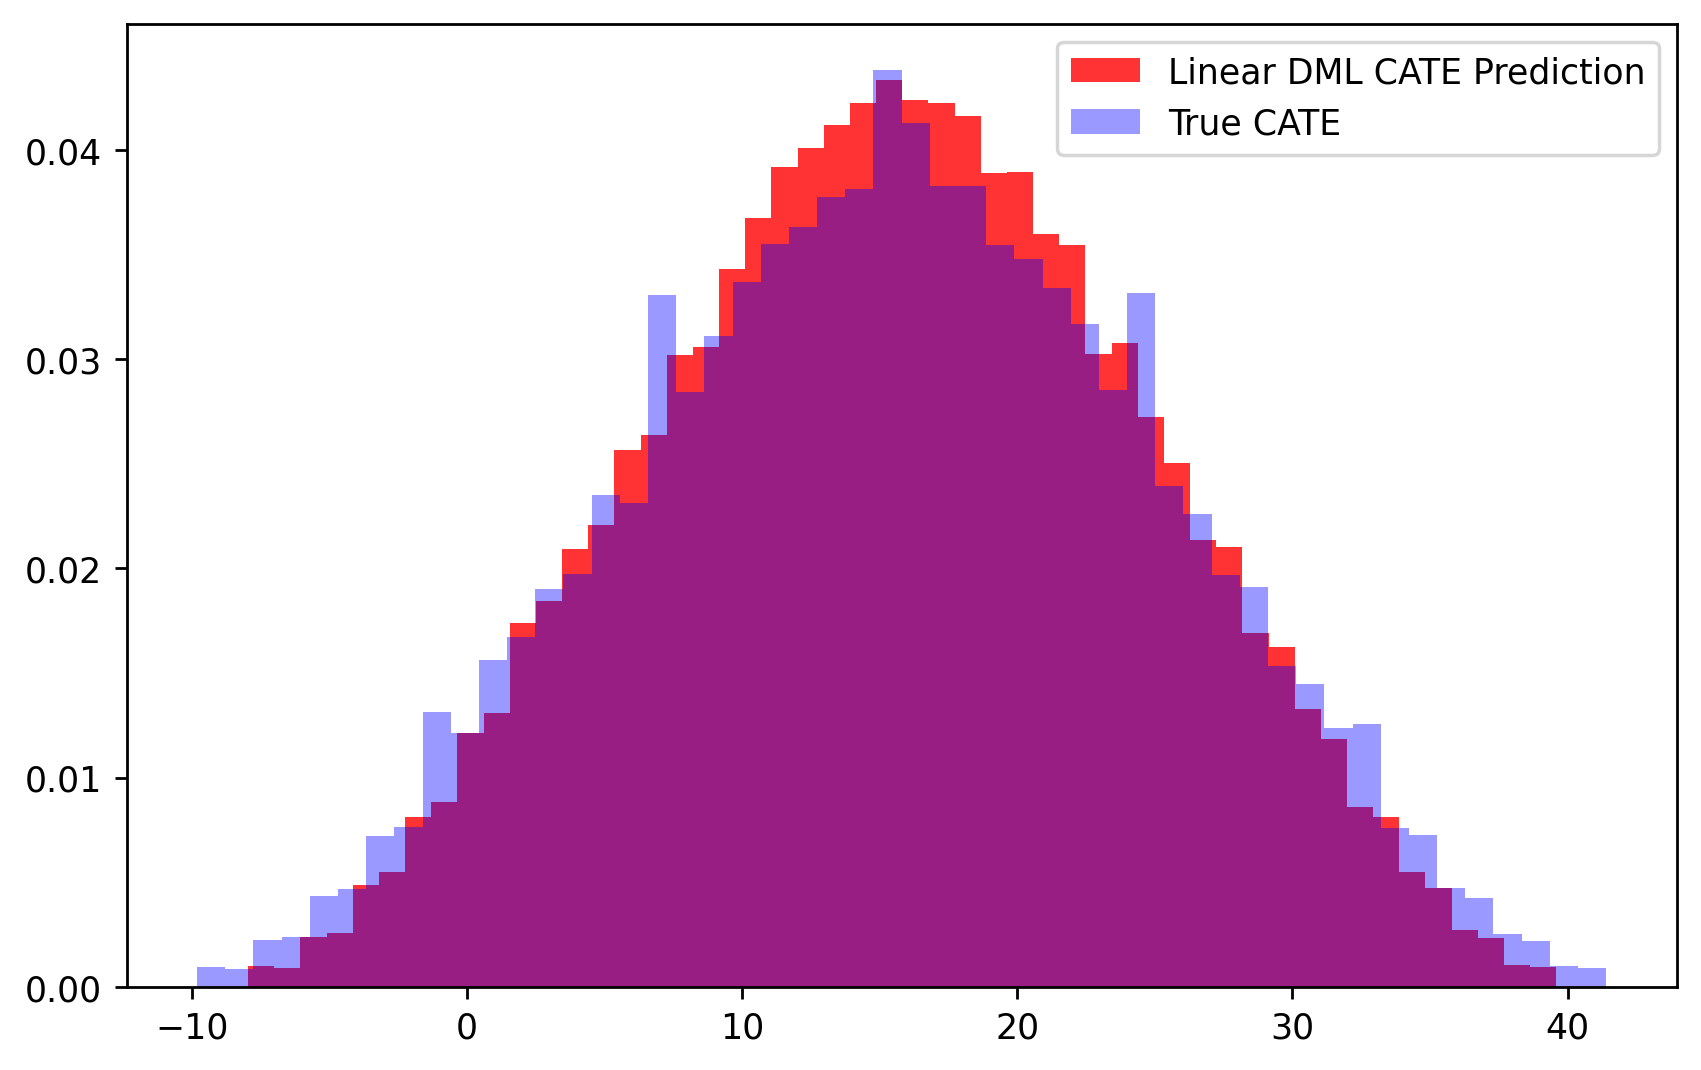

In [112]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8,5),dpi=250)

ax.hist(df_predictions['linear_DML_CATE'], color='r',alpha=0.8, density=True, bins=50, label='Linear DML CATE Prediction')
ax.hist(df_predictions['true_CATE'], color='b',alpha=0.4, density=True, bins=50, label='True CATE')

ax.legend()
plt.show()

In [113]:
print(f"MSE: {mean_squared_error(df_predictions['true_CATE'], df_predictions['linear_DML_CATE'])}")
print(f"R2: {r2_score(df_predictions['true_CATE'], df_predictions['linear_DML_CATE'])}")
print(f"MAE: {mean_absolute_error(df_predictions['true_CATE'], df_predictions['linear_DML_CATE'])}")

MSE: 0.4459628162796798
R2: 0.9950804428645063
MAE: 0.5445596001878896


### Linear DML w/ Non-Linear CATE Function

In [8]:
N = 100_000

# Confounders
age = np.random.randint(low=18,high=75,size=N)
num_social_media_profiles = np.random.choice([0,1,2,3,4,5,6,7,8,9,10], size = N)
yr_membership = np.random.choice([0,1,2,3,4,5,6,7,8,9,10], size = N)

# Covariates
X = np.random.normal(loc=50, scale = 25, size = N)

# Error Terms
ε1 = np.random.normal(loc=20,scale=5,size=N)
ε2 = np.random.normal(loc=40,scale=15,size=N)

# Treatment (T)
time_on_website = np.maximum( np.random.normal(loc=10, scale=5, size=N) 
                             - 0.01*age 
                             - 0.001*age**2 
                             + num_social_media_profiles 
                             - 0.01 * num_social_media_profiles**2
                             - 0.01*(age * num_social_media_profiles)
                             + 0.2 * yr_membership
                             + 0.001 * yr_membership**2
                             - 0.01 * (age * yr_membership)
                             + 0.2 * (num_social_media_profiles * yr_membership)
                             + 0.01 * (num_social_media_profiles * np.log(age) * age * yr_membership**(1/2))
                             + ε1
                               ,0)

# Outcome (y)
sales = np.maximum( np.random.normal(loc=25, scale=10, size=N)
                             +  5 * time_on_website # Simulated ATE = 5
                             -  0.2 * time_on_website * age
                             - 0.0005 * time_on_website * age**2
                             + 0.8 * time_on_website * num_social_media_profiles
                             + 0.001 * time_on_website * num_social_media_profiles**2
                             + 0.8 * time_on_website * yr_membership 
                             + 0.001 * time_on_website * yr_membership**2
                             + 0.005 * time_on_website * yr_membership * num_social_media_profiles * age
                             + 0.005 * time_on_website * (yr_membership**3 / (1 + num_social_media_profiles**2)) * np.log(age) ** 2
                             - 0.1*age 
                             - 0.001*age**2 
                             + 8 * num_social_media_profiles 
                             - 0.1 * num_social_media_profiles**2
                             - 0.01*(age * num_social_media_profiles)
                             + 2 * yr_membership
                             + 0.1 * yr_membership**2
                             - 0.01 * (age * yr_membership)
                             + 3 * (num_social_media_profiles * yr_membership)
                             + 0.1 * (num_social_media_profiles * np.log(age) * age * yr_membership**(1/2))
                             + 0.5 * X
                             + ε2
                               ,0)

df = pd.DataFrame(np.array([sales,time_on_website,age,num_social_media_profiles,yr_membership,X]).T
                  ,columns=["sales","time_on_website","age","num_social_media_profiles","yr_membership","X"])

In [115]:
# DML Procedure
M_sales = GradientBoostingRegressor()
M_time_on_website = GradientBoostingRegressor()

residualized_sales = df["sales"] - cross_val_predict(M_sales, df[["age","num_social_media_profiles","yr_membership"]], df['sales'], cv=3)
residualized_time_on_website = df['time_on_website'] - cross_val_predict(M_time_on_website, df[["age","num_social_media_profiles","yr_membership"]], df['time_on_website'], cv=3)

df['residualized_sales'] = residualized_sales
df['residualized_time_on_website'] = residualized_time_on_website

DML_model = smf.ols(formula='residualized_sales ~ 1 + residualized_time_on_website + residualized_time_on_website:age + residualized_time_on_website:num_social_media_profiles + residualized_time_on_website:yr_membership', data = df).fit()
print(DML_model.summary())

                            OLS Regression Results                            
Dep. Variable:     residualized_sales   R-squared:                       0.616
Model:                            OLS   Adj. R-squared:                  0.616
Method:                 Least Squares   F-statistic:                 4.013e+04
Date:                Mon, 10 Jul 2023   Prob (F-statistic):               0.00
Time:                        11:00:49   Log-Likelihood:            -5.9038e+05
No. Observations:              100000   AIC:                         1.181e+06
Df Residuals:                   99995   BIC:                         1.181e+06
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                                             coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------

In [116]:
# Predict CATE of 1 hour increase
df_predictions = df[['residualized_time_on_website','age','num_social_media_profiles','yr_membership']].copy()
df_predictions['linear_DML_CATE']= (DML_model.predict(df_predictions.assign(residualized_time_on_website= lambda x : x.residualized_time_on_website + 1)) 
                                    - DML_model.predict(df_predictions))

# True CATE of 1 hour increase
df_predictions['true_CATE'] = (5 - 0.2*df_predictions['age'] - 0.0005*df_predictions['age']**2 + 0.8*df_predictions['num_social_media_profiles'] + 0.001*df_predictions['num_social_media_profiles']**2 
                   + 0.8*df_predictions['yr_membership'] + 0.001*df_predictions['yr_membership']**2 + 0.005*df_predictions['yr_membership']*df_predictions['num_social_media_profiles']*df_predictions['age']
                   + + 0.005 * (df_predictions['yr_membership']**3 / (1 + df_predictions['num_social_media_profiles']**2)) * np.log(df_predictions['age'])**2)

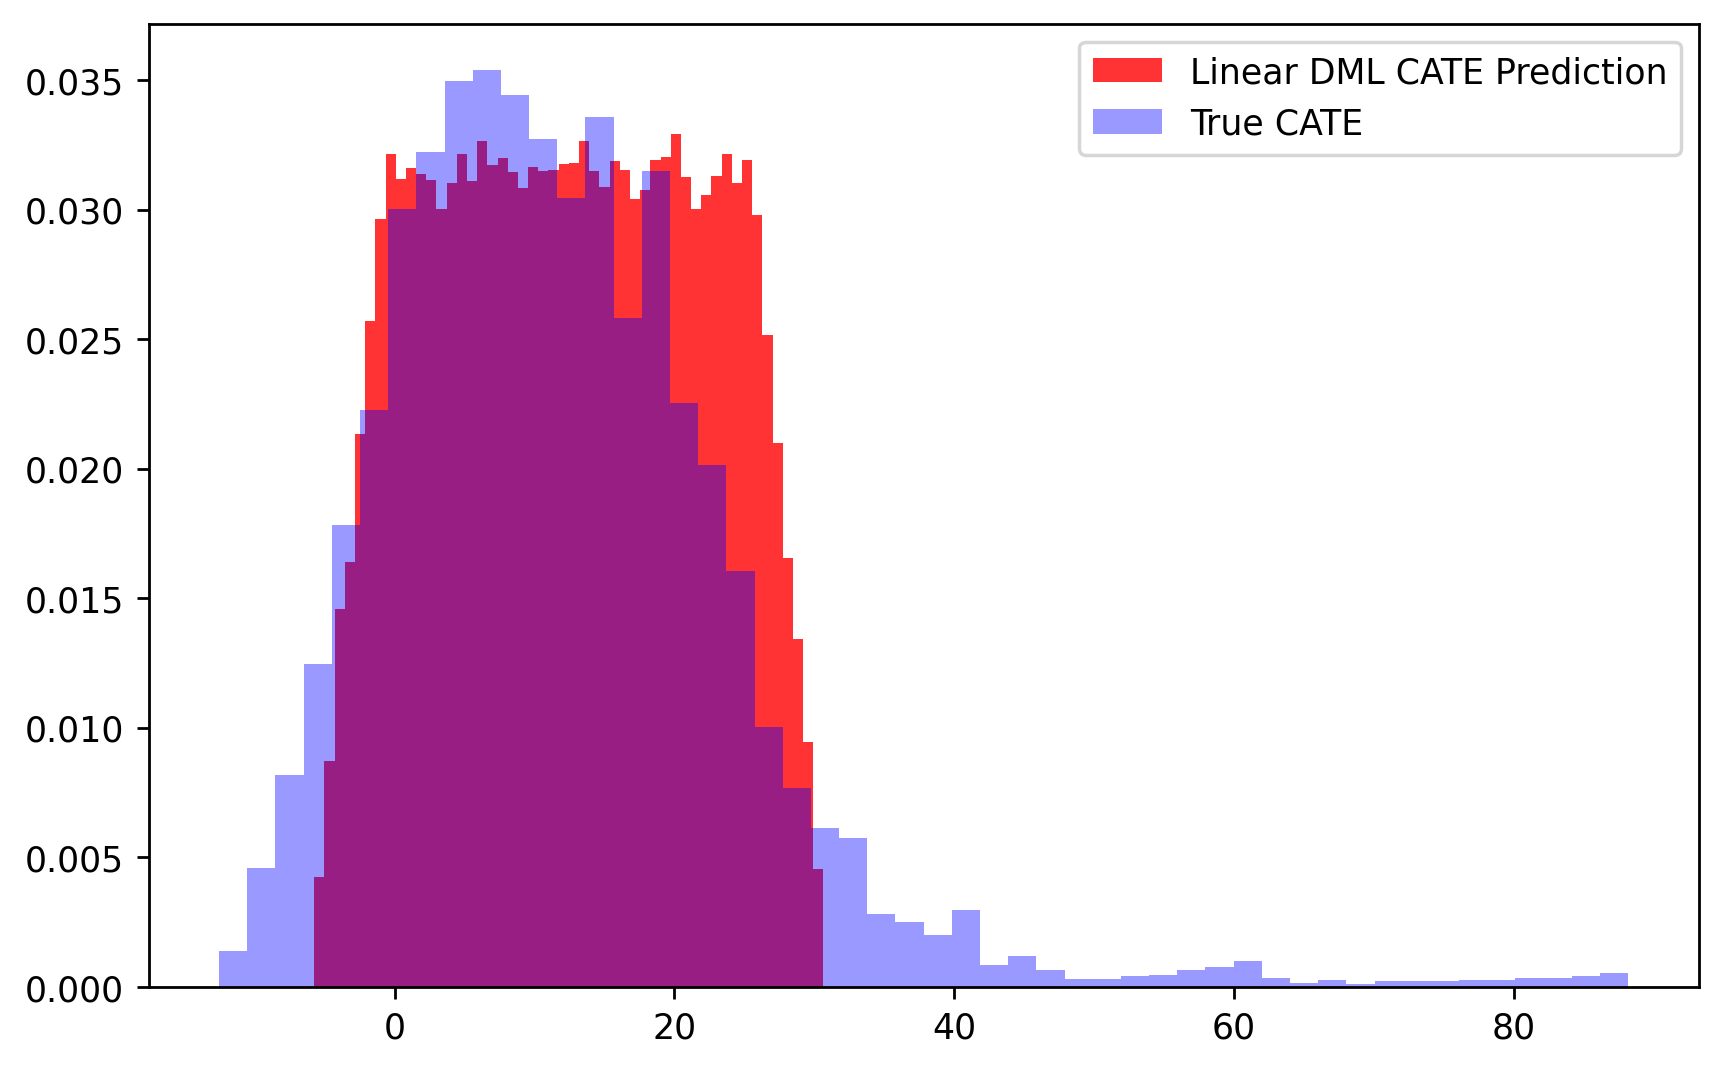

In [117]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8,5),dpi=250)

ax.hist(df_predictions['linear_DML_CATE'], color='r',alpha=0.8, density=True, bins=50, label='Linear DML CATE Prediction')
ax.hist(df_predictions['true_CATE'], color='b', density=True, alpha=0.4, bins=50, label='True CATE')

ax.legend()
plt.show()

In [118]:
print(f"MSE: {mean_squared_error(df_predictions['true_CATE'], df_predictions['linear_DML_CATE'])}")
print(f"R2: {r2_score(df_predictions['true_CATE'], df_predictions['linear_DML_CATE'])}")
print(f"MAE: {mean_absolute_error(df_predictions['true_CATE'], df_predictions['linear_DML_CATE'])}")

MSE: 55.91588472253966
R2: 0.6489851385940888
MAE: 4.502287638445688


### Non-Parametric DML

In [119]:
df['target'] = df['residualized_sales'] / df['residualized_time_on_website']
df['weights'] = df['residualized_time_on_website']**2

In [120]:
CATE_model = GradientBoostingRegressor()
CATE_model.fit(df[["age","num_social_media_profiles","yr_membership"]], df['target'], sample_weight=df['weights'])

df_predictions['Non_Parametric_DML_CATE'] = CATE_model.predict(df[["age","num_social_media_profiles","yr_membership"]])

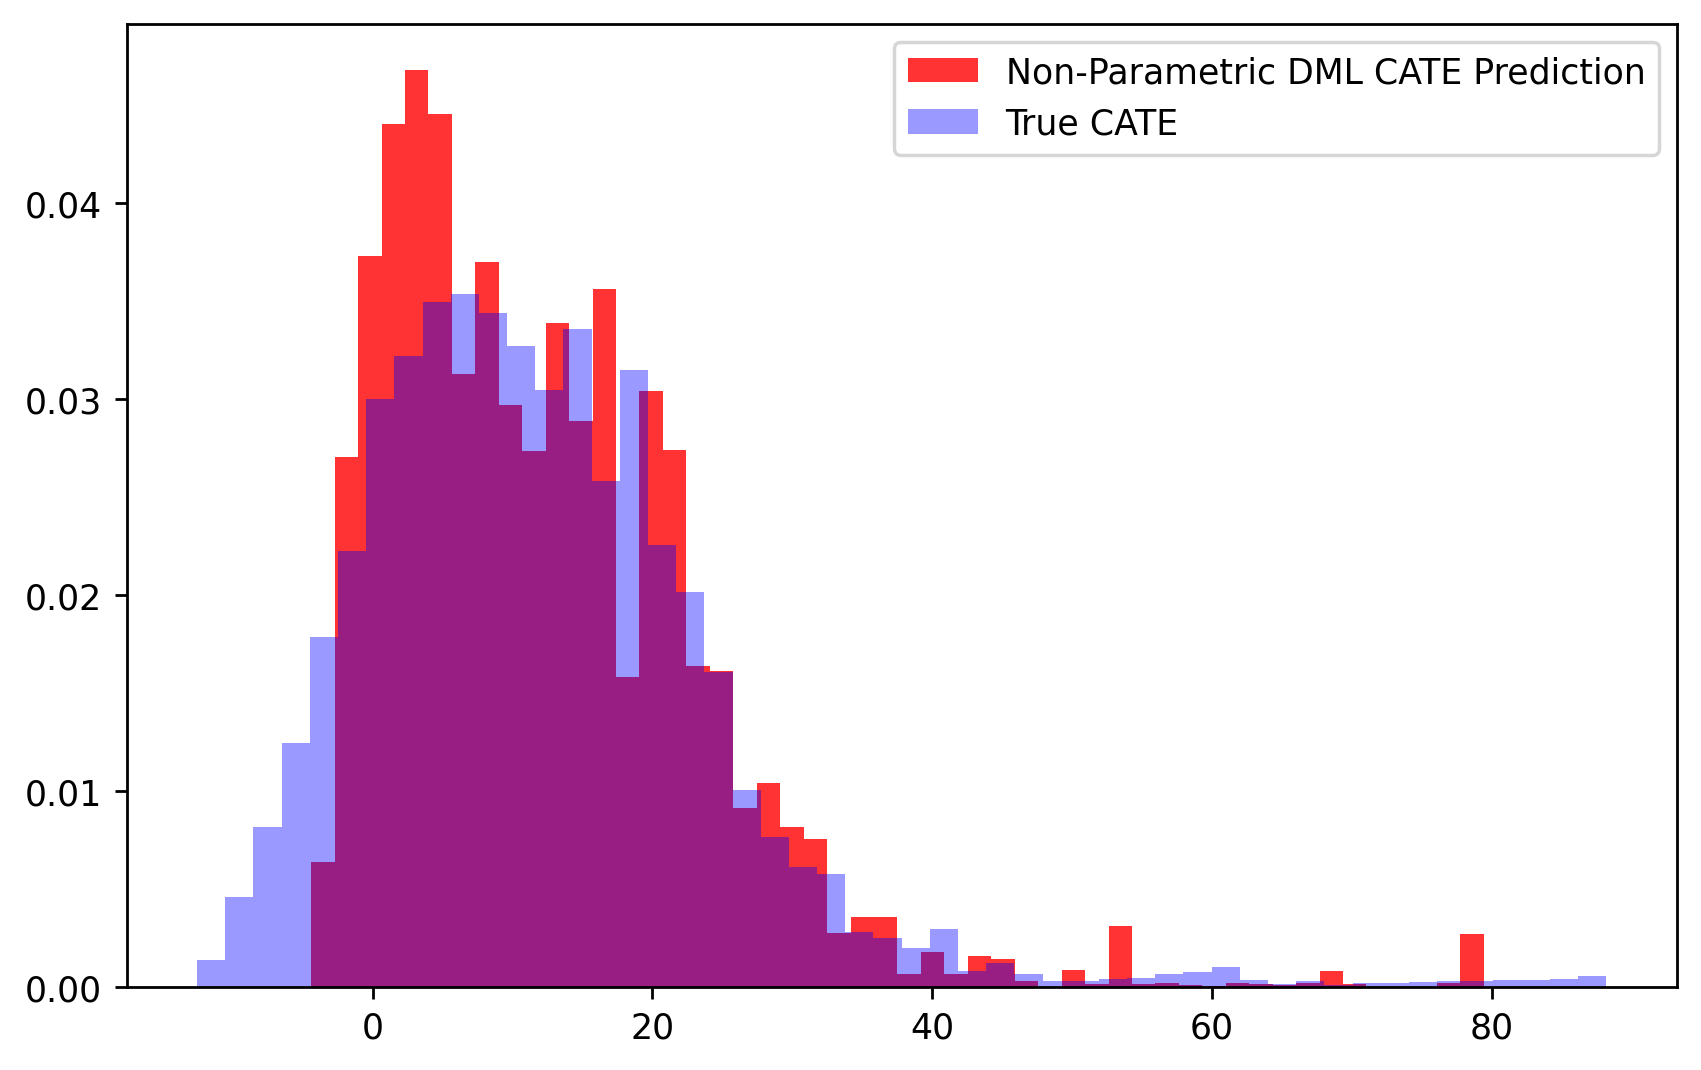

In [121]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8,5),dpi=250)

ax.hist(df_predictions['Non_Parametric_DML_CATE'], color='r',alpha=0.8, density=True, bins=50, label='Non-Parametric DML CATE Prediction')
ax.hist(df_predictions['true_CATE'], color='b', density=True, alpha=0.4, bins=50, label='True CATE')

ax.legend()
plt.show()

In [122]:
print(f"MSE: {mean_squared_error(df_predictions['true_CATE'], df_predictions['Non_Parametric_DML_CATE'])}")
print(f"R2: {r2_score(df_predictions['true_CATE'], df_predictions['Non_Parametric_DML_CATE'])}")
print(f"MAE: {mean_absolute_error(df_predictions['true_CATE'], df_predictions['Non_Parametric_DML_CATE'])}")

MSE: 4.605207332013297
R2: 0.971090572537422
MAE: 1.3712808789111182
